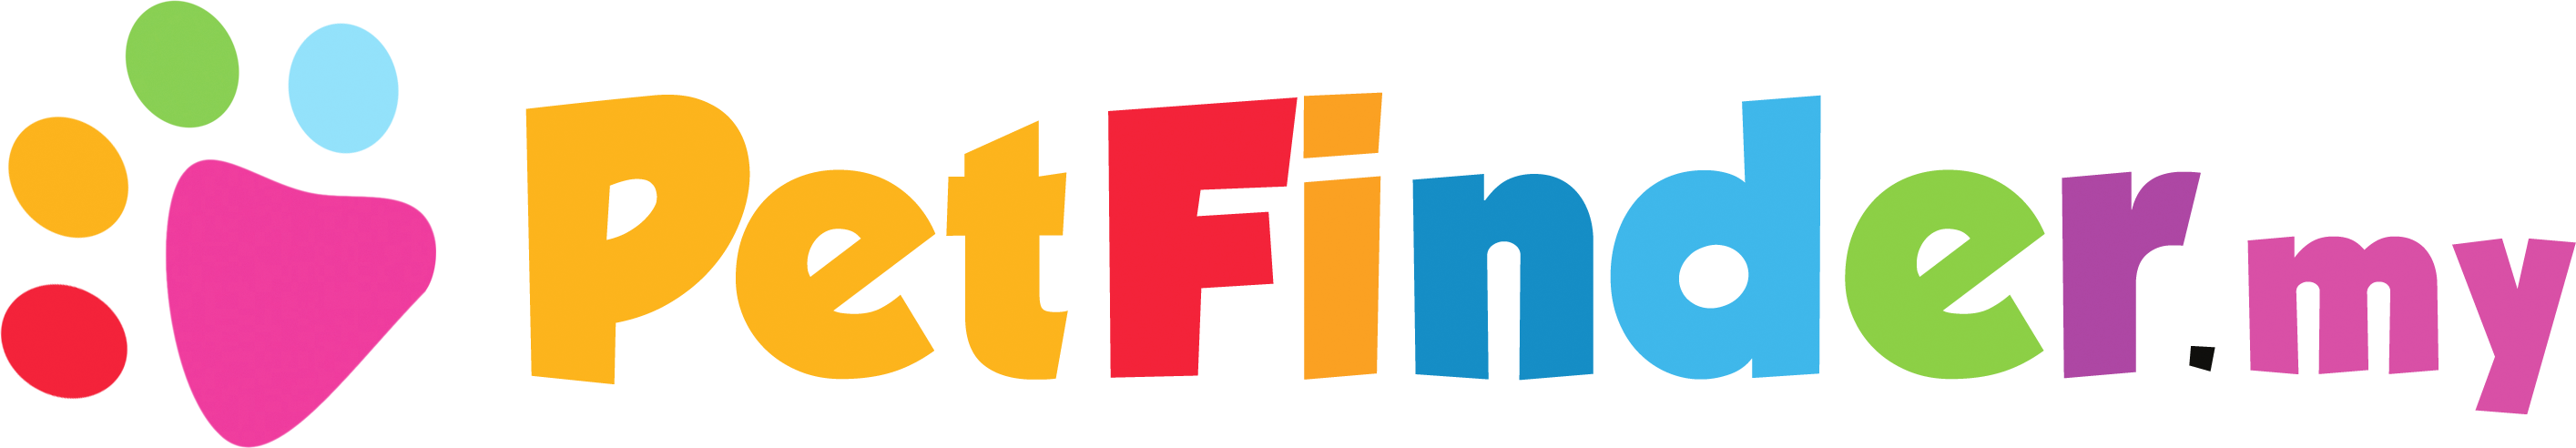
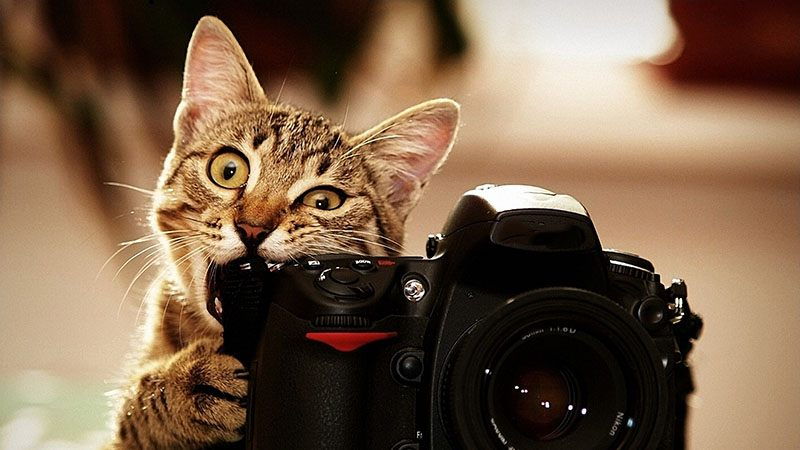
PetFinder.my is Malaysia’s leading animal welfare platform, featuring over 180,000 animals with 54,000 happily adopted. PetFinder collaborates closely with animal lovers, media, corporations, and global organizations to improve animal welfare.

Currently, PetFinder.my uses a basic Cuteness Meter to rank pet photos. It analyzes picture composition and other factors compared to the performance of thousands of pet profiles. While this basic tool is helpful, it's still in an experimental stage and the algorithm could be improved.

In this competition, you’ll analyze raw images and metadata to predict the “Pawpularity” of pet photos. You'll train and test your model on PetFinder.my's thousands of pet profiles. Winning versions will offer accurate recommendations that will improve animal welfare.

If successful, your solution will be adapted into AI tools that will guide shelters and rescuers around the world to improve the appeal of their pet profiles, automatically enhancing photo quality and recommending composition improvements. As a result, stray dogs and cats can find their "furever" homes much faster. With a little assistance from the Kaggle community, many precious lives could be saved and more happy families created.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import sys
import warnings
warnings.filterwarnings("ignore")

## 1. Import train and test data

- Focus - Pet stands out against uncluttered background, not too close / far.
- Eyes - Both eyes are facing front or near-front, with at least 1 eye / pupil decently clear.
- Face - Decently clear face, facing front or near-front.
- Near - Single pet taking up significant portion of photo (roughly over 50% of photo width or height).
- Action - Pet in the middle of an action (e.g., jumping).
- Accessory - Accompanying physical or digital accessory / prop (i.e. toy, digital sticker), excluding collar and leash.
- Group - More than 1 pet in the photo.
- Collage - Digitally-retouched photo (i.e. with digital photo frame, combination of multiple photos).
- Human - Human in the photo.
- Occlusion - Specific undesirable objects blocking part of the pet (i.e. human, cage or fence). Note that not all blocking objects are considered occlusion.
- Info - Custom-added text or labels (i.e. pet name, description).
- Blur - Noticeably out of focus or noisy, especially for the pet’s eyes and face. For Blur entries, “Eyes” column is always set to 0.

In [2]:
train=pd.read_csv('petfinder-pawpularity-score/train.csv')
test=pd.read_csv('petfinder-pawpularity-score/test.csv')

In [3]:
train.head(5)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [4]:
train.drop(['Id'],axis=1,inplace=True)

In [5]:
# Check for data types and null entries
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Subject Focus  9912 non-null   int64
 1   Eyes           9912 non-null   int64
 2   Face           9912 non-null   int64
 3   Near           9912 non-null   int64
 4   Action         9912 non-null   int64
 5   Accessory      9912 non-null   int64
 6   Group          9912 non-null   int64
 7   Collage        9912 non-null   int64
 8   Human          9912 non-null   int64
 9   Occlusion      9912 non-null   int64
 10  Info           9912 non-null   int64
 11  Blur           9912 non-null   int64
 12  Pawpularity    9912 non-null   int64
dtypes: int64(13)
memory usage: 1006.8 KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             8 non-null      object
 1   Subject Focus  8 non-null      int64 
 2   Eyes           8 non-null      int64 
 3   Face           8 non-null      int64 
 4   Near           8 non-null      int64 
 5   Action         8 non-null      int64 
 6   Accessory      8 non-null      int64 
 7   Group          8 non-null      int64 
 8   Collage        8 non-null      int64 
 9   Human          8 non-null      int64 
 10  Occlusion      8 non-null      int64 
 11  Info           8 non-null      int64 
 12  Blur           8 non-null      int64 
dtypes: int64(12), object(1)
memory usage: 960.0+ bytes


## 2. EDA

## 2.1 Feature Correlation
- Rule of thumb: If the correlation > 0.8 then severe multicollinearity may be present.

Text(0.5, 1.0, 'Correlation heatmap')

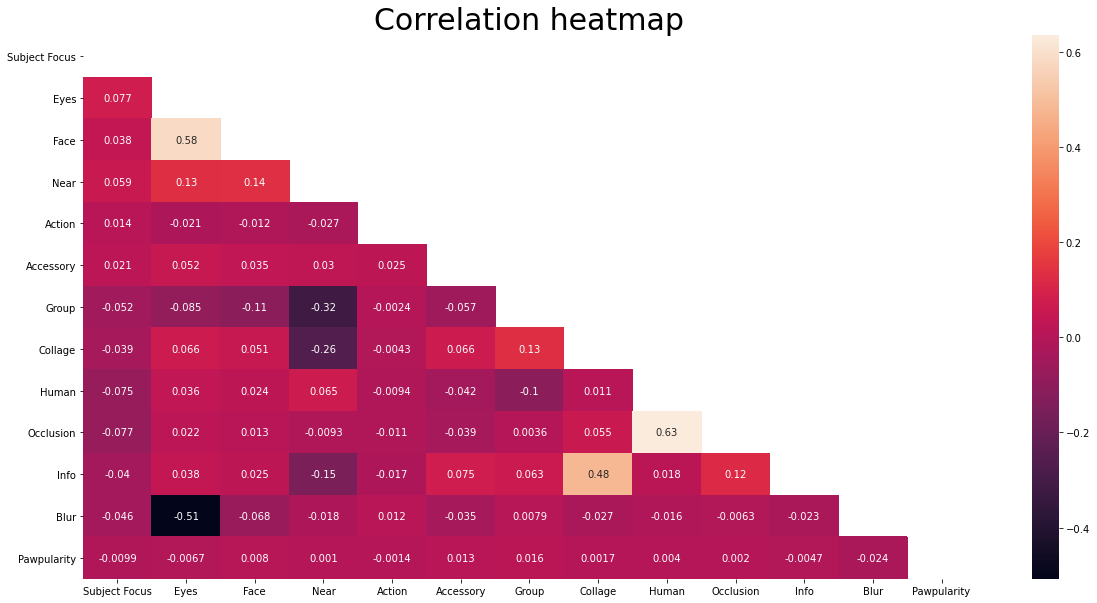

In [7]:
mask = np.zeros_like(train.corr()*-1)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,10))
sns.heatmap(train.corr(),mask=mask,annot=True)

plt.title('Correlation heatmap',fontsize=30)

In [8]:
# It is clear that 
#'Human and Occlusion' are the most positively correlated.
#'Eyes and Blur' are the most negatively correlated.

<AxesSubplot:>

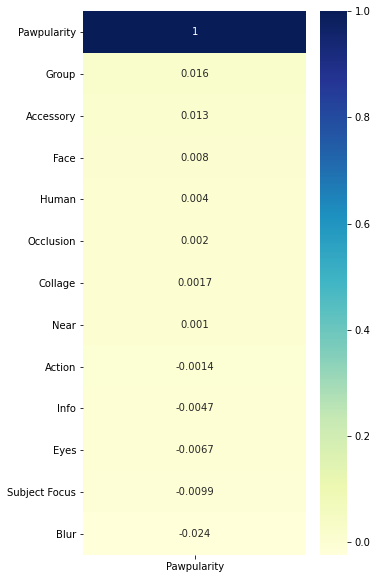

In [9]:
# Rank the correlation of independent variables with the dependent variables
sorted_paw=train.corr().sort_values(by='Pawpularity',ascending=False)[['Pawpularity']]

plt.figure(figsize=(5,10))
sns.heatmap(sorted_paw,annot=True,cmap="YlGnBu")

## 2.2 Feature Importance - RandomForest Regressor

<Figure size 432x288 with 0 Axes>

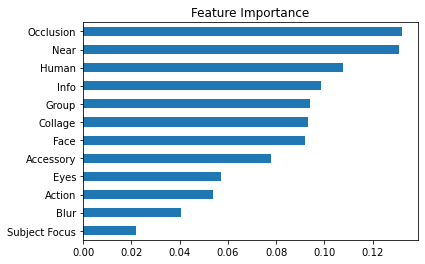

In [10]:
from sklearn.ensemble import RandomForestRegressor
feature_model=RandomForestRegressor()
feature_model.fit(train.loc[:,'Subject Focus':'Blur'],train.Pawpularity)
important_features=pd.DataFrame(feature_model.feature_importances_,index=train.loc[:,'Subject Focus':'Blur'].columns)

plt.figure()
important_features.sort_values(by=0).plot(kind='barh',legend=False,title='Feature Importance') # 0 is the column name here. 
plt.show()

## 2.3 Countplots

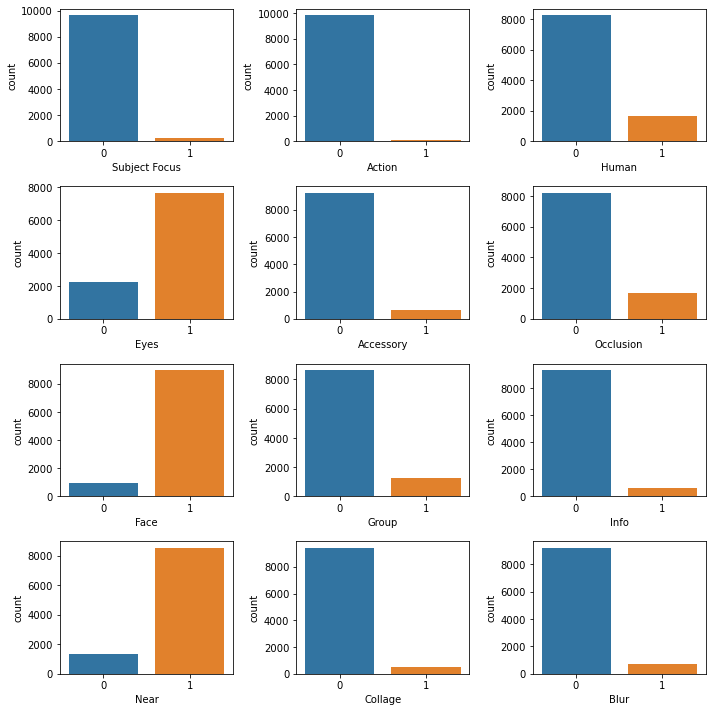

In [11]:
fig, ax = plt.subplots(4,3,figsize=(10,10))

for i, feature in enumerate(train.loc[:,'Subject Focus':'Blur'].columns):
    sns.countplot(train.loc[:,'Subject Focus':'Blur'][feature],ax=ax[i%4, i//4],data=train.loc[:,'Subject Focus':'Blur'])
    
plt.tight_layout()

## 2.4 Pawpularity histogram

Text(0.5, 1.0, 'Distribution of Pawpularity')

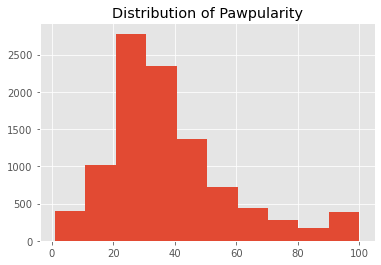

In [12]:
plt.style.use('ggplot')
plt.hist(train.Pawpularity, bins=10)
plt.title('Distribution of Pawpularity')

## 3. Model Implementation with Cross Validation

In [13]:
## Cross Validation with 5 folds
k=5
kf=KFold(n_splits=k,random_state=1)

In [14]:
df_train=train.loc[:,'Subject Focus':'Blur']
target=train[['Pawpularity']]

### Model 1: Random Forest Regression
- Hyperparameters: Max_depth, n_estimators

In [15]:
def RF(X_train,X_test,y_train,y_test):
    
    min_rmse=sys.maxsize
    depth_list=[1,2,3]
    estimators=[100,200,500]
    for depth in depth_list:
        for estim in estimators:
            model=RandomForestRegressor(n_estimators=estim,max_depth=depth)
            model.fit(X_train,y_train)
            predictions=model.predict(X_test)
            rmse=sqrt(mean_squared_error(predictions,y_test))
            print('The random forest regression model with a max_depth={} n_estimator={} results in a RMSE of {}.'
                  .format(depth,estim,rmse))
            
            if rmse<min_rmse:
                min_rmse=rmse
                best_para=[depth,estim]
                
    return[min_rmse,best_para]
        

### Model 2: XGBoost Regression
- Hyperparameters: Max_depth, n_estimators

In [16]:
def xgb(X_train,X_test,y_train,y_test):
    min_rmse=sys.maxsize

    
    depth_list=[1,2,3]
    estimators=[100,200,500]
    for depth in depth_list:
        for estim in estimators:
            model=XGBRegressor(n_estimators=estim,max_depth=depth)
            model.fit(X_train,y_train)
            predictions=model.predict(X_test)
            rmse=sqrt(mean_squared_error(predictions,y_test))
            print('The XGBoost regression model with a max_depth={},n_estimators={} results in a RMSE of {}.'
                  .format(depth,estim,rmse))
            
            if rmse<min_rmse:
                min_rmse=rmse
                best_para=[depth,estim]
                
    return[min_rmse,best_para]
        

In [17]:
fold = 1
min_xgb_rmse=sys.maxsize
min_rf_rmse=sys.maxsize

#Iterate through each cross-validation fold
for train_index , test_index in kf.split(train):
    X_train , X_test = df_train.iloc[train_index,:],df_train.iloc[test_index,:] #train - training; test - validation
    y_train , y_test = target.iloc[train_index,:] ,target.iloc[test_index,:]
    
    print('Fold {}:'.format(fold))
    
    #Random Forest Regressor
    rf_rmse,rf_para=RF(X_train,X_test,y_train,y_test)
    if rf_rmse < min_rf_rmse:
        min_rf_rmse=rf_rmse
        best_rf_para=[fold,rf_para]
    
    #XGB Regressor
    xgb_rmse,xgb_para=xgb(X_train,X_test,y_train,y_test)
    if xgb_rmse < min_xgb_rmse:
        min_xgb_rmse=xgb_rmse
        best_xgb_para=[fold,xgb_para]
    
    fold+=1
    
print('XGB model yields the lowest RMSE of {} when fold={}, max_depth={},n_estimators={}'
     .format(min_xgb_rmse,best_xgb_para[0],best_xgb_para[1][0],best_xgb_para[1][1]))

print('Random Forest model yields the lowest RMSE of {} when fold={}, max_depth={},n_estimators={}'
     .format(min_rf_rmse,best_rf_para[0],best_rf_para[1][0],best_rf_para[1][1]))

Fold 1:
The random forest regression model with a max_depth=1 n_estimator=100 results in a RMSE of 20.704480572125103.
The random forest regression model with a max_depth=1 n_estimator=200 results in a RMSE of 20.70305707904576.
The random forest regression model with a max_depth=1 n_estimator=500 results in a RMSE of 20.70350273822482.
The random forest regression model with a max_depth=2 n_estimator=100 results in a RMSE of 20.70633626191265.
The random forest regression model with a max_depth=2 n_estimator=200 results in a RMSE of 20.70469338670105.
The random forest regression model with a max_depth=2 n_estimator=500 results in a RMSE of 20.703406238686707.
The random forest regression model with a max_depth=3 n_estimator=100 results in a RMSE of 20.700592028463948.
The random forest regression model with a max_depth=3 n_estimator=200 results in a RMSE of 20.695292458413643.
The random forest regression model with a max_depth=3 n_estimator=500 results in a RMSE of 20.70287870913737

The random forest regression model with a max_depth=2 n_estimator=200 results in a RMSE of 20.398995099364235.
The random forest regression model with a max_depth=2 n_estimator=500 results in a RMSE of 20.398240852328755.
The random forest regression model with a max_depth=3 n_estimator=100 results in a RMSE of 20.394865869306045.
The random forest regression model with a max_depth=3 n_estimator=200 results in a RMSE of 20.39272862340444.
The random forest regression model with a max_depth=3 n_estimator=500 results in a RMSE of 20.395304135668663.
The XGBoost regression model with a max_depth=1,n_estimators=100 results in a RMSE of 20.416474774829137.
The XGBoost regression model with a max_depth=1,n_estimators=200 results in a RMSE of 20.423594640210986.
The XGBoost regression model with a max_depth=1,n_estimators=500 results in a RMSE of 20.4259931798596.
The XGBoost regression model with a max_depth=2,n_estimators=100 results in a RMSE of 20.40859545183862.
The XGBoost regression mo

In [18]:
# Based on the training results, Random Forest model outperforms with Fold =4, max_depth=3,n_estimators=500

## 4. Model Testing

In [19]:
# Extract the fourth fold
count = 1
for train_index , test_index in kf.split(train):
    X_train , X_test = df_train.iloc[train_index,:],df_train.iloc[test_index,:] #train - training; test - validation
    y_train , y_test = target.iloc[train_index,:] ,target.iloc[test_index,:]
    if count == 4: 
        break
    else:
        count+=1
        

In [24]:
# Fit the model with best parameters
best_model=RandomForestRegressor(n_estimators=500,max_depth=3)
best_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=3, n_estimators=500)

In [25]:
# Orignal test dataset with 8 entries
test.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [26]:
test_predictions=best_model.predict(test.drop(['Id'],axis=1))
print(test_predictions)

[37.94192331 35.94979439 37.51325506 36.15585072 32.7823078  40.15841917
 31.44548509 36.31745209]


In [27]:
output = pd.DataFrame({"Id": test.Id, "pawpularity": test_predictions})
output.to_csv('submission.csv', index = False)

## 5. Kaggle Submission Results
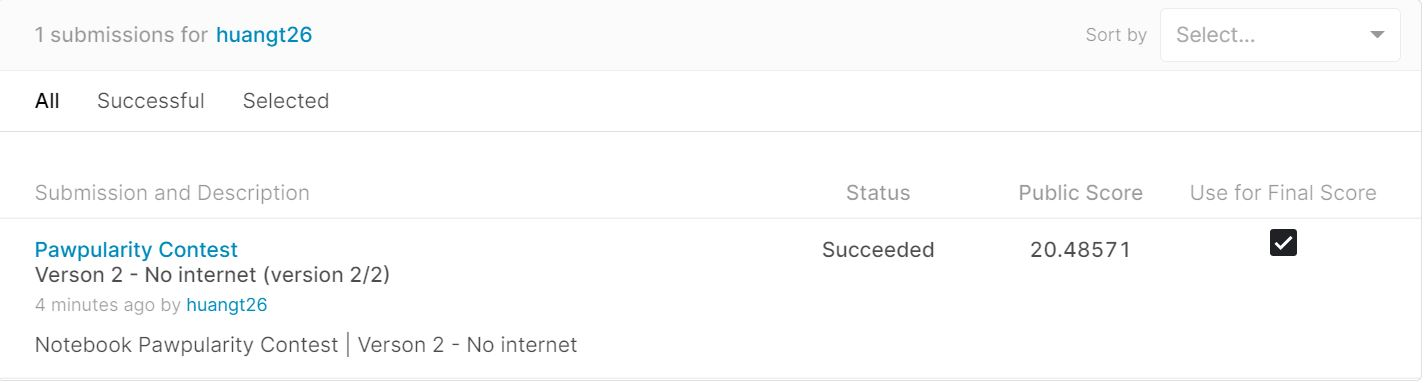

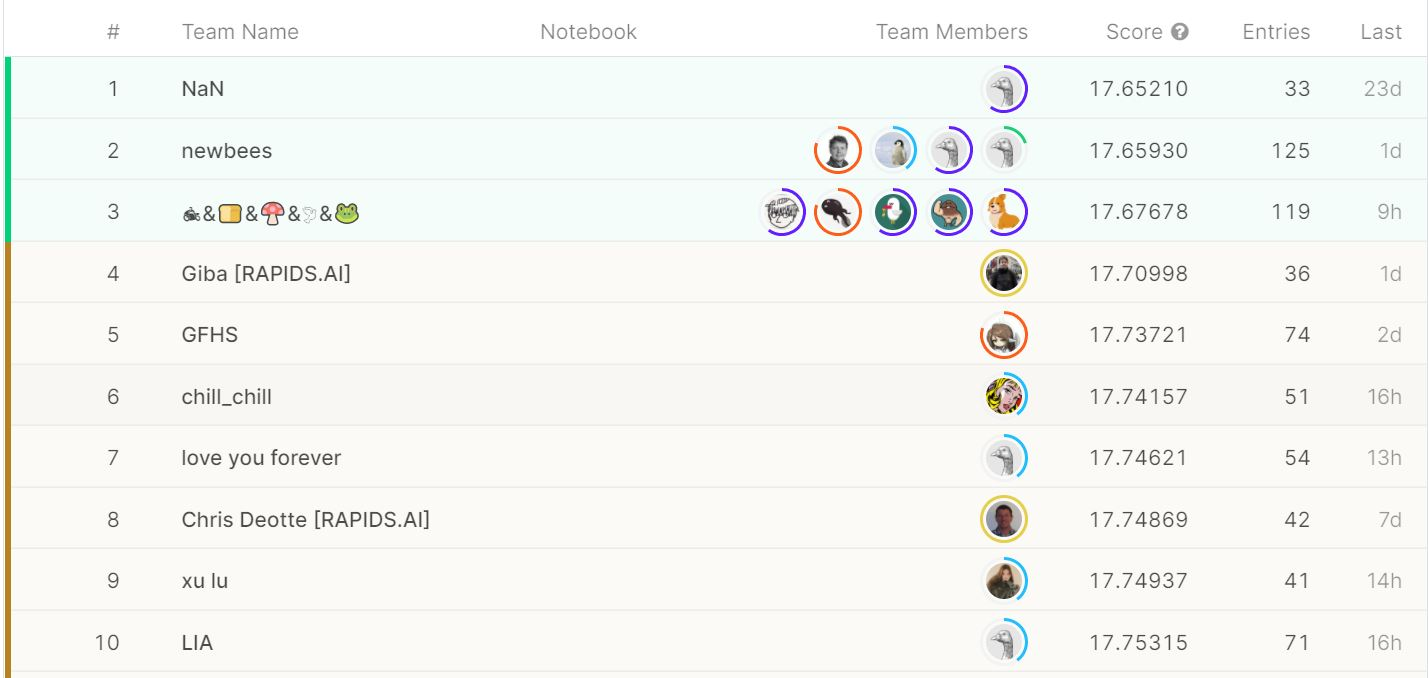